In [1]:
import csv
import os

import sys

sys.path.append('C:/Users/vodou/Documents/Python Scripts')

import prog_tools as pt
import computer_interface as ci

import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import welch

In [2]:
def plot_ecg(item, sampling_rate=300, N=300):
    ecg_signal = item  # Replace `item` with your ECG data array or list

    # Calculate the time axis in seconds
    time = [i / sampling_rate for i in range(len(ecg_signal))]

    # Plot the ECG signal
    plt.figure(figsize=(35, 4))
    plt.plot(time[:N], ecg_signal[:N], color='orange', linewidth=1)
    plt.title("ECG Reading")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

In [3]:
def plot_peaks(ecg_signal, r_peaks, sampling_rate=300, N=300):
    # Limit the ECG signal and time axis to the first N points
    ecg_signal = ecg_signal[:N]
    time = [i / sampling_rate for i in range(len(ecg_signal))]

    # Filter R-peaks to include only those within the first N points
    valid_r_peaks = [i for i in r_peaks if i < N]  # Ensure indices are valid
    time_indices = [time[i] for i in valid_r_peaks]  # Convert indices to time for x-axis

    # Plot the ECG signal
    plt.figure(figsize=(35, 12))
    plt.plot(time, ecg_signal, color='orange', linewidth=1)

    # Plot a vertical line at each specified index
    for t in time_indices:
        plt.axvline(x=t, color='red', linestyle='--', linewidth=1)

    plt.title("ECG Signal with Vertical Lines at R-peaks (First N Points)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

In [4]:
def plot_features(signal):
    r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
    # print(r_peaks)
    if len(r_peaks) >= 2:
        # print(ecg.extract_heartbeats(signal, r_peaks, 300))
        beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0)
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)

            plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat', color='blue')
            # Fill the variance range
            plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
            # Plot a median
            plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='orange')

In [5]:
def heartbeat_extractor(all_ecg_signals):

    heartbeat_array = []

    for ecg_signal in all_ecg_signals:
        r_peaks = ecg.engzee_segmenter(ecg_signal, sampling_rate=300)['rpeaks']
        beats = ecg.extract_heartbeats(ecg_signal, r_peaks, sampling_rate=300)['templates']
        if len(beats) > 0:
            ...
        elif len(beats) == 0:
            r_peaks = ecg.hamilton_segmenter(ecg_signal, sampling_rate=300)['rpeaks']
            beats = ecg.extract_heartbeats(ecg_signal, r_peaks, sampling_rate=300)['templates']

        heartbeat_array.append(beats)

    return heartbeat_array

In [6]:
def drop_na(data):

    data_array = []

    for i in range(0, len(data)):

        ecg_sample = data.loc[i].dropna().to_numpy(dtype='float32')
        data_array.append(ecg_sample)

    return data_array

In [7]:
def calc_stats(beats):
    mu = np.mean(beats, axis=0)
    var = np.std(beats, axis=0)
    md = np.median(beats, axis=0)
    return mu, var, md

In [8]:
def extract_ecg_intervals_biosppy(all_signals, sampling_rate=300):

    feature_array = []

    for ecg_signal in all_signals:

        r_peaks = ecg.engzee_segmenter(ecg_signal, sampling_rate=300)['rpeaks']
        beats = ecg.extract_heartbeats(ecg_signal, r_peaks, sampling_rate=300)['templates']
        if len(beats) > 0:
            ...
        elif len(beats) == 0:
            r_peaks = ecg.hamilton_segmenter(ecg_signal, sampling_rate=300)['rpeaks']
            beats = ecg.extract_heartbeats(ecg_signal, r_peaks, sampling_rate=300)['templates']

        # Initialize lists to store intervals
        rr_intervals = []
        qrs_durations = []

        r_amplitudes = []
        q_amplitudes = []

        for beat in beats:
            r_index = beat.argmax()  # Index of R peak (maximum value)
            r_amplitude = beat[r_index]  # Amplitude of R-wave
            r_amplitudes.append(r_amplitude)

            if r_index > 0:
                q_index = beat[:r_index].argmin()  # Index of Q trough (before the R-wave)
                q_amplitude = beat[q_index]  # Amplitude of Q-wave
            else:
                q_amplitude = 0

            q_amplitudes.append(q_amplitude)

        for i in range(1, len(r_peaks)):
            rr_interval = (r_peaks[i] - r_peaks[i - 1]) / sampling_rate  # RR interval in seconds
            rr_intervals.append(rr_interval)

        for beat in beats:
            qrs_duration = (beat.argmax() - beat.argmin()) / sampling_rate  # Duration in seconds
            qrs_durations.append(qrs_duration)

        feature_array.append([rr_intervals, qrs_durations, r_amplitudes, q_amplitudes])

    return feature_array

In [9]:
def feature_summary(rr_intervals, qrs_durations, r_amplitudes, q_amplitudes):
    rr_mu = np.mean(rr_intervals) if rr_intervals else np.nan
    rr_std = np.std(rr_intervals) if rr_intervals else np.nan
    rr_min = np.min(rr_intervals) if rr_intervals else np.nan
    rr_max = np.max(rr_intervals) if rr_intervals else np.nan
    qrs_mu = np.mean(qrs_durations) if qrs_durations else np.nan
    qrs_std = np.std(qrs_durations) if qrs_durations else np.nan
    qrs_min = np.min(qrs_durations) if qrs_durations else np.nan
    qrs_max = np.max(qrs_durations) if qrs_durations else np.nan
    r_mu = np.mean(r_amplitudes) if r_amplitudes else np.nan
    r_std = np.std(r_amplitudes) if r_amplitudes else np.nan
    r_min = np.min(r_amplitudes) if r_amplitudes else np.nan
    r_max = np.max(r_amplitudes) if r_amplitudes else np.nan
    q_mu = np.mean(q_amplitudes) if q_amplitudes else np.nan
    q_std = np.std(q_amplitudes) if q_amplitudes else np.nan
    q_min = np.min(q_amplitudes) if q_amplitudes else np.nan
    q_max = np.max(q_amplitudes) if q_amplitudes else np.nan

    return [rr_mu, rr_std, rr_min, rr_max, qrs_mu, qrs_std, qrs_min, qrs_max, r_mu, r_std, r_min, r_max, q_mu, q_std, q_min, q_max]


In [10]:
def summarise_features(extra_features):
    summarised_features = []
    for rr_intervals, qrs_durations, r_amplitudes, q_amplitudes in extra_features:
         summary = feature_summary(rr_intervals, qrs_durations, r_amplitudes, q_amplitudes)
         summarised_features.append(summary)
    return summarised_features

In [11]:
def compile_stats(total_beats, extra_features):
    data = []

    for i in range(len(total_beats)):
        if len(total_beats[i]) != 0:
            mu, var, md = calc_stats(total_beats[i])
            data.append([mu, var, md])

    flattened = [np.concatenate([mu, var, md]) for mu, var, md in data]
    Y = np.vstack(flattened)

    feature_data = summarise_features(extra_features)

    X = np.hstack((np.array(flattened), np.array(feature_data)))
    return X

In [12]:
def evaluate_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    return f1

In [13]:
def visualise_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [14]:
train_data = pd.read_csv('train.csv', index_col='id')
test_data = pd.read_csv('test.csv', index_col='id')

In [15]:
y_train = train_data['y'].to_numpy()

In [16]:
train_data = train_data.drop(columns=['y'])

In [17]:
train_array = drop_na(train_data)
test_array = drop_na(test_data)

In [18]:
manual_train_features = extract_ecg_intervals_biosppy(train_array)
manual_test_features = extract_ecg_intervals_biosppy(test_array)

In [19]:
print(len(manual_train_features))
len(manual_test_features)

5117


3411

In [20]:
total_train_beats = heartbeat_extractor(train_array)
total_test_beats = heartbeat_extractor(test_array)

In [21]:
X_train = compile_stats(total_train_beats, manual_train_features)
X_test = compile_stats(total_test_beats, manual_test_features)

In [22]:
np.array(X_train).shape

(5117, 556)

In [23]:
np.array(X_test).shape

(3411, 556)

In [117]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [118]:
f1 = evaluate_model(model, X_train, y_train)

In [119]:
f1

0.73046875

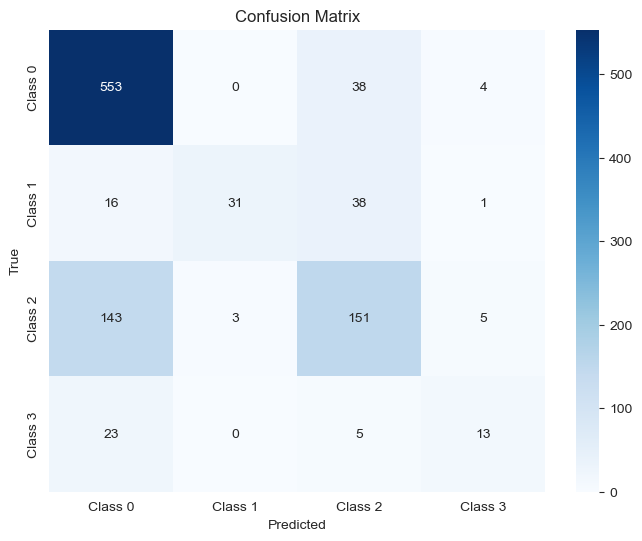

In [120]:
visualise_model(model, X_train, y_train)

In [121]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [122]:
len(y_pred)

3411

In [123]:
ci.save_predictions(y_pred, 'C:/Users/vodou/Documents/Academic/MA1/Advanced Machine Learning/Tasks/Task_2/predictions.csv')